## AutoEncoderで異常検知(Optunaでチューニング）

In [1]:
!pip install optuna

In [2]:
%load_ext lab_black

In [3]:
# ライブラリのインポート
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import optuna
from sklearn.preprocessing import StandardScaler

import warnings

warnings.simplefilter("ignore")

qtdb/sel102 ECG dataset [2] という心電図データ

http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt


In [4]:
df = pd.read_csv("../../data/qtdbsel102.txt", header=None, delimiter="\t")
df.head()

,0,1,2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440


傾向の確認

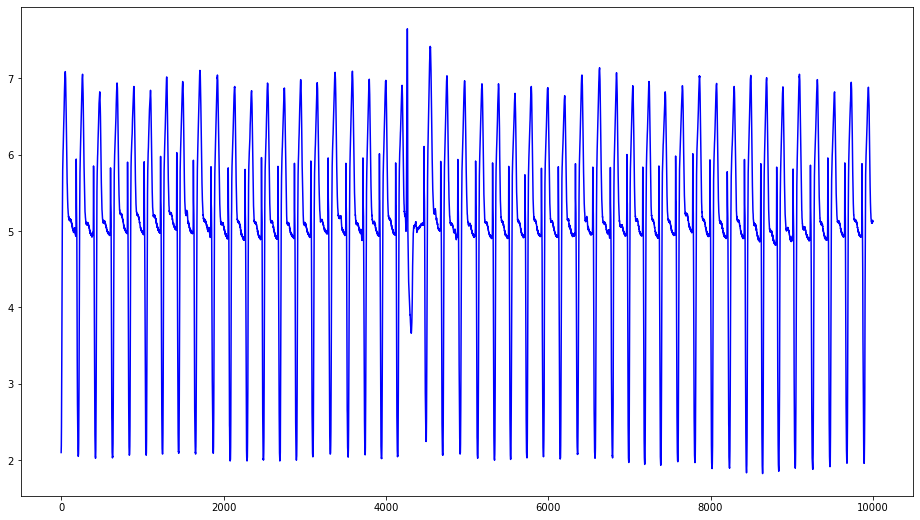

In [5]:
ecg_dataset = df.iloc[:, 2].values
ecg_dataset = ecg_dataset[:10000]
ecg_dataset = ecg_dataset.reshape(len(ecg_dataset), -1)

plt.figure(figsize=(16, 9))
plt.plot(ecg_dataset, color="b")
plt.show()

異常箇所の確認

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

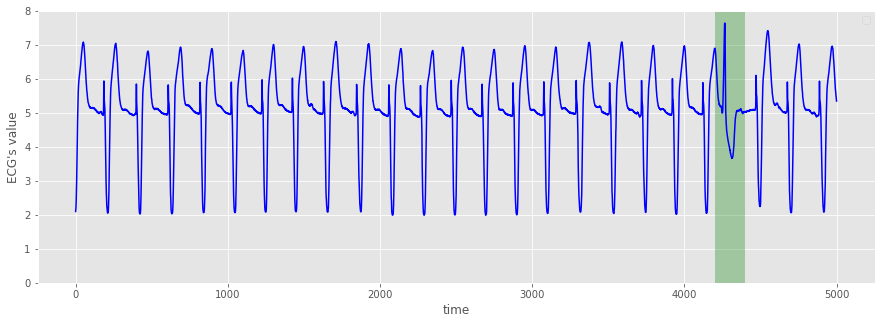

In [6]:
plt.figure()

plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.xlabel("time")
plt.ylabel("ECG's value")
plt.plot(np.arange(5000), ecg_dataset[:5000], color="b")
plt.ylim(0, 8)
x = np.arange(4200, 4400)
y1 = [0] * len(x)
y2 = [8] * len(x)
plt.fill_between(x, y1, y2, facecolor="g", alpha=0.3)
plt.legend()

plt.show()

データセットを正規化し、学習データとテストデータに分割

In [7]:
# 平均値を0にする
ecg_dataset_mean = ecg_dataset.mean()
ecg_dataset = ecg_dataset - ecg_dataset_mean

# データセットの最大値で割り、-1～1の範囲に収まるように正規化する
ecg_dataset_max = np.abs(ecg_dataset).max()
ecg_dataset = ecg_dataset / ecg_dataset_max

In [8]:
train_data = ecg_dataset[5000:10000]
test_data = ecg_dataset[:5000]

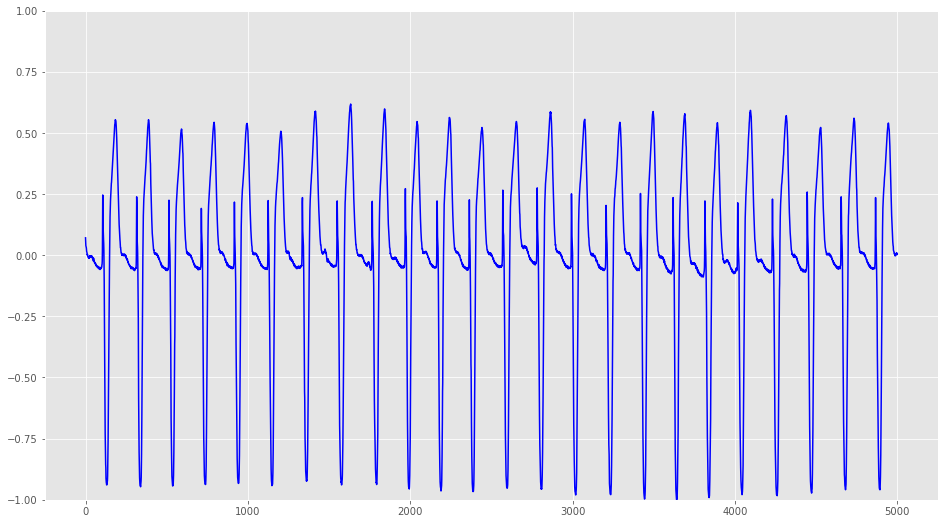

In [9]:
# 学習データプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(train_data, color="b")
plt.show()

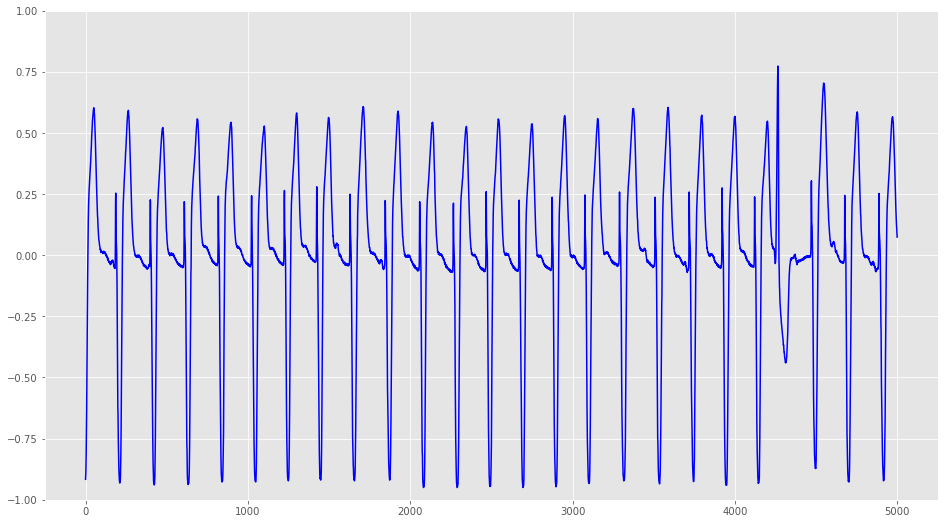

In [10]:
# テストデータプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(test_data, color="b")
plt.show()

#### オートエンコーダ モデル構築

- データセットは時系列データをズラしながらサンプリングして作成
- 今回は1ポイントずつズラしてデータを作成
- 学習データセットとテストデータセットを作成

In [11]:
TIME_STEPS = 128


def create_dataset_list(array, time_steps=TIME_STEPS):
    dataset_list = []

    for i in range(len(array) - time_steps + 1):
        dataset_list.append(array[i : (i + time_steps)])

    return np.stack(dataset_list)

In [12]:
x_train = create_dataset_list(train_data)

print(train_data.shape)
print(x_train.shape)

(5000, 1)
(4873, 128, 1)


In [13]:
x_test = create_dataset_list(test_data)

print(test_data.shape)
print(x_test.shape)

(5000, 1)
(4873, 128, 1)


In [14]:
seed = 10
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### Optunaを使用したモデル構造探索

Kerasのシーケンシャルモデルを構築します。

- 入力サイズ(time_steps)
- レイヤー数(num_layer)
- 畳み込みフィルター数(num_filters)
- 畳み込みカーネルサイズ(kernel_size)
- 畳み込みストライドサイズ(strides)
- ドロップアウト割合(dropout_rate)
- 活性化関数(activation)

In [15]:
def create_model(
    time_steps, num_layer, num_filters, kernel_size, strides, dropout_rate, activation
):
    model = tf.keras.Sequential()

    # 入力層
    model.add(tf.keras.layers.InputLayer(input_shape=(time_steps, 1)))

    # エンコード層
    for i in range(num_layer):
        filters = int(num_filters / (i + 1))

        model.add(
            tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                padding="same",
                strides=strides,
                activation=activation,
            )
        )
        if i < (num_layer - 1):
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # デコード層
    for i in reversed(range(num_layer)):
        filters = int(num_filters / (i + 1))

        model.add(
            tf.keras.layers.Conv1DTranspose(
                filters=filters,
                kernel_size=kernel_size,
                padding="same",
                strides=strides,
                activation=activation,
            )
        )
        if i != 0:
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # 出力層
    model.add(
        tf.keras.layers.Conv1DTranspose(
            filters=1, kernel_size=kernel_size, padding="same"
        )
    )

    return model

In [16]:
def objective(trial):
    # レイヤー数
    num_layer = trial.suggest_int("num_layer", 1, 3)
    # 畳み込みフィルター数
    num_filters = int(trial.suggest_categorical("num_filters", [16, 32, 64]))
    # 畳み込みカーネルサイズ
    kernel_size = trial.suggest_int("kernel_size", 1, 5, 2)
    # 畳み込みストライドサイズ
    strides = trial.suggest_int("strides", 2, 4, 2)
    # ドロップアウト割合
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    # 活性化関数
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "tanh"])

    # 最適化アルゴリズム
    optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam"])

    # モデル構築・コンパイル
    model = create_model(
        TIME_STEPS,
        num_layer,
        num_filters,
        kernel_size,
        strides,
        dropout_rate,
        activation,
    )
    model.compile(optimizer=optimizer, loss="mse")

    model.summary()

    # 訓練開始
    history = model.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )

    return history.history["val_loss"][-1]

In [17]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-08-18 12:02:18,122] A new study created in memory with name: no-name-79b5171b-8009-4bdf-9cf4-49dd65baccda


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 16)            64        
_________________________________________________________________
dropout (Dropout)            (None, 64, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 8)             392       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 5)             125       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 32, 5)             80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 5)             0

[I 2021-08-18 12:04:55,985] Trial 0 finished with value: 0.01044868677854538 and parameters: {'num_layer': 3, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.4744626885117062, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.01044868677854538.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 64, 64)            128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 64, 32)            1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 32)            0         
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 128, 64)           2112      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 128, 1)           

[I 2021-08-18 12:08:25,392] Trial 1 finished with value: 0.11201141774654388 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 1, 'strides': 2, 'dropout_rate': 0.26077803785197284, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.01044868677854538.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 32, 32)            128       
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 128, 32)           3104      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 128, 1)            97        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 59ms/step - loss: 0.0993 - val_loss: 0.0193
Epoch 2/50
35/35 [==============================] - 1s 43ms/step - loss: 0.0092 - val_loss: 0.0017
Epoch 3/50
35/35 [==============================] - 2s 47ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/50
35/35 [==============================] - 2s 53ms/step - loss: 9.8069e-04 -

[I 2021-08-18 12:09:49,554] Trial 2 finished with value: 4.24158715759404e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.33345867120924744, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 32, 32)            128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 16)             1552      
_________________________________________________________________
conv1d_transpose_9 (Conv1DTr (None, 32, 16)            784       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_transpose_10 (Conv1DT (None, 128, 32)           1568      
_________________________________________________________________
conv1d_transpose_11 (Conv1DT (None, 128, 1)           

[I 2021-08-18 12:11:26,151] Trial 3 finished with value: 0.028911693021655083 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.08997735428797315, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 32, 16)            32        
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8, 8)              136       
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 32, 8)             72        
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 8)             0         
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 128, 16)           144       
_________________________________________________________________
conv1d_transpose_14 (Conv1DT (None, 128, 1)           

[I 2021-08-18 12:12:37,508] Trial 4 finished with value: 0.13457563519477844 and parameters: {'num_layer': 2, 'num_filters': 16, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.16925473597661128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 32, 64)            128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 32)             2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2, 21)             693       
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 8, 21)             462       
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 21)            

[I 2021-08-18 12:13:36,091] Trial 5 finished with value: 0.13781167566776276 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.2893325424885962, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 64, 32)            128       
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 32, 16)            1552      
_________________________________________________________________
conv1d_transpose_19 (Conv1DT (None, 64, 16)            784       
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 16)            0         
_________________________________________________________________
conv1d_transpose_20 (Conv1DT (None, 128, 32)           1568      
_________________________________________________________________
conv1d_transpose_21 (Conv1DT (None, 128, 1)           

[I 2021-08-18 12:15:49,244] Trial 6 finished with value: 0.13803459703922272 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.15842837917875668, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 32, 32)            192       
_________________________________________________________________
conv1d_transpose_22 (Conv1DT (None, 128, 32)           5152      
_________________________________________________________________
conv1d_transpose_23 (Conv1DT (None, 128, 1)            161       
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 10s 159ms/step - loss: 0.0850 - val_loss: 0.0650
Epoch 2/50
35/35 [==============================] - 3s 96ms/step - loss: 0.0551 - val_loss: 0.0390
Epoch 3/50
35/35 [==============================] - 2s 58ms/step - loss: 0.0329 - val_loss: 0.0213
Epoch 4/50
35/35 [==============================] - 3s 89ms/step - loss: 0.0179 - v

[I 2021-08-18 12:18:29,831] Trial 7 finished with value: 0.0013347235508263111 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.0353508155619231, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 64, 16)            96        
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 16)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 32, 8)             648       
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 8)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 16, 5)             205       
_________________________________________________________________
conv1d_transpose_24 (Conv1DT (None, 32, 5)             130       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 5)            

[I 2021-08-18 12:21:27,797] Trial 8 finished with value: 0.003079533576965332 and parameters: {'num_layer': 3, 'num_filters': 16, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.2908183208756818, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 64, 16)            96        
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 16)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 32, 8)             648       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16, 5)             205       
_________________________________________________________________
conv1d_transpose_28 (Conv1DT (None, 32, 5)             130       
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 5)            

[I 2021-08-18 12:24:51,617] Trial 9 finished with value: 0.003588812192901969 and parameters: {'num_layer': 3, 'num_filters': 16, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.3045028811641564, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 32, 32)            128       
_________________________________________________________________
conv1d_transpose_32 (Conv1DT (None, 128, 32)           3104      
_________________________________________________________________
conv1d_transpose_33 (Conv1DT (None, 128, 1)            97        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 4s 73ms/step - loss: 0.0947 - val_loss: 0.0160
Epoch 2/50
35/35 [==============================] - 2s 68ms/step - loss: 0.0071 - val_loss: 0.0015
Epoch 3/50
35/35 [==============================] - 2s 50ms/step - loss: 0.0013 - val_loss: 9.6834e-04
Epoch 4/50
35/35 [==============================] - 2s 51ms/step - loss: 8.7608e

[I 2021-08-18 12:26:40,121] Trial 10 finished with value: 4.701107900473289e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.4214962230678996, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 32, 32)            128       
_________________________________________________________________
conv1d_transpose_34 (Conv1DT (None, 128, 32)           3104      
_________________________________________________________________
conv1d_transpose_35 (Conv1DT (None, 128, 1)            97        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 7s 139ms/step - loss: 0.0931 - val_loss: 0.0080
Epoch 2/50
35/35 [==============================] - 2s 63ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 3/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0013 - val_loss: 8.9393e-04
Epoch 4/50
35/35 [==============================] - 3s 88ms/step - loss: 8.7877

[I 2021-08-18 12:28:23,977] Trial 11 finished with value: 4.3995976739097387e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.4254104314257895, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 32, 32)            128       
_________________________________________________________________
conv1d_transpose_36 (Conv1DT (None, 128, 32)           3104      
_________________________________________________________________
conv1d_transpose_37 (Conv1DT (None, 128, 1)            97        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 5s 95ms/step - loss: 0.1033 - val_loss: 0.0251
Epoch 2/50
35/35 [==============================] - 1s 42ms/step - loss: 0.0117 - val_loss: 0.0019
Epoch 3/50
35/35 [==============================] - 2s 58ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/50
35/35 [==============================] - 1s 41ms/step - loss: 0.0010 - va

[I 2021-08-18 12:30:03,235] Trial 12 finished with value: 5.1471237384248525e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.38689803635968195, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 32, 32)            128       
_________________________________________________________________
conv1d_transpose_38 (Conv1DT (None, 128, 32)           3104      
_________________________________________________________________
conv1d_transpose_39 (Conv1DT (None, 128, 1)            97        
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 14s 218ms/step - loss: 0.1125 - val_loss: 0.0446
Epoch 2/50
35/35 [==============================] - 5s 134ms/step - loss: 0.0260 - val_loss: 0.0023
Epoch 3/50
35/35 [==============================] - 4s 128ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/50
35/35 [==============================] - 5s 135ms/step - loss: 0.0011

[I 2021-08-18 12:32:42,700] Trial 13 finished with value: 5.4014792112866417e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.37516908534561777, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 32, 32)            64        
_________________________________________________________________
conv1d_transpose_40 (Conv1DT (None, 128, 32)           1056      
_________________________________________________________________
conv1d_transpose_41 (Conv1DT (None, 128, 1)            33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 2s 37ms/step - loss: 0.1222 - val_loss: 0.1070
Epoch 2/50
35/35 [==============================] - 1s 27ms/step - loss: 0.1000 - val_loss: 0.1038
Epoch 3/50
35/35 [==============================] - 1s 25ms/step - loss: 0.0992 - val_loss: 0.1035
Epoch 4/50
35/35 [==============================] - 1s 29ms/step - loss: 0.0990 - va

[I 2021-08-18 12:33:03,178] Trial 14 finished with value: 0.10339389741420746 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.49486132699192076, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 4.24158715759404e-05.


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 32, 32)            192       
_________________________________________________________________
conv1d_transpose_42 (Conv1DT (None, 128, 32)           5152      
_________________________________________________________________
conv1d_transpose_43 (Conv1DT (None, 128, 1)            161       
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 2s 43ms/step - loss: 0.0915 - val_loss: 0.0073
Epoch 2/50
35/35 [==============================] - 1s 35ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 8.3754e-04
Epoch 4/50
35/35 [==============================] - 1s 38ms/step - loss: 8.5232e

[I 2021-08-18 12:34:04,847] Trial 15 finished with value: 1.0799972187669482e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.3536858461459148, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 15 with value: 1.0799972187669482e-05.


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_44 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_45 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 61ms/step - loss: 0.0832 - val_loss: 0.0027
Epoch 2/50
35/35 [==============================] - 2s 61ms/step - loss: 0.0024 - val_loss: 9.3221e-04
Epoch 3/50
35/35 [==============================] - 2s 54ms/step - loss: 8.8810e-04 - val_loss: 6.1828e-04
Epoch 4/50
35/35 [==============================] - 2s 55ms/step - los

[I 2021-08-18 12:35:46,247] Trial 16 finished with value: 5.527388566406444e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.3434775654014508, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 16 with value: 5.527388566406444e-06.


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 8, 32)             10272     
_________________________________________________________________
conv1d_transpose_46 (Conv1DT (None, 32, 32)            5152      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32)            0         
_________________________________________________________________
conv1d_transpose_47 (Conv1DT (None, 128, 64)           10304     
_________________________________________________________________
conv1d_transpose_48 (Conv1DT (None, 128, 1)          

[I 2021-08-18 12:37:45,268] Trial 17 finished with value: 0.0002784866082947701 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.22571832037873601, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 16 with value: 5.527388566406444e-06.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_49 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_50 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 67ms/step - loss: 0.0609 - val_loss: 0.0023
Epoch 2/50
35/35 [==============================] - 2s 51ms/step - loss: 0.0021 - val_loss: 9.2039e-04
Epoch 3/50
35/35 [==============================] - 2s 54ms/step - loss: 9.1183e-04 - val_loss: 6.6730e-04
Epoch 4/50
35/35 [==============================] - 2s 55ms/step - los

[I 2021-08-18 12:39:19,675] Trial 18 finished with value: 5.659624548570719e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.20208799605286762, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 16 with value: 5.527388566406444e-06.


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_51 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_52 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 63ms/step - loss: 0.0714 - val_loss: 0.0030
Epoch 2/50
35/35 [==============================] - 2s 52ms/step - loss: 0.0023 - val_loss: 8.7134e-04
Epoch 3/50
35/35 [==============================] - 2s 56ms/step - loss: 8.0805e-04 - val_loss: 5.1426e-04
Epoch 4/50
35/35 [==============================] - 2s 51ms/step - los

[I 2021-08-18 12:40:55,935] Trial 19 finished with value: 3.603007826313842e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.19720144020243696, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 19 with value: 3.603007826313842e-06.


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 64, 64)            384       
_________________________________________________________________
dropout_26 (Dropout)         (None, 64, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 32, 32)            10272     
_________________________________________________________________
conv1d_transpose_53 (Conv1DT (None, 64, 32)            5152      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64, 32)            0         
_________________________________________________________________
conv1d_transpose_54 (Conv1DT (None, 128, 64)           10304     
_________________________________________________________________
conv1d_transpose_55 (Conv1DT (None, 128, 1)          

[I 2021-08-18 12:43:36,344] Trial 20 finished with value: 0.00011159194400534034 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.11228748192544277, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 19 with value: 3.603007826313842e-06.


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_56 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_57 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 4s 68ms/step - loss: 0.0651 - val_loss: 0.0030
Epoch 2/50
35/35 [==============================] - 2s 52ms/step - loss: 0.0023 - val_loss: 8.7922e-04
Epoch 3/50
35/35 [==============================] - 2s 67ms/step - loss: 8.4977e-04 - val_loss: 5.4035e-04
Epoch 4/50
35/35 [==============================] - 2s 55ms/step - los

[I 2021-08-18 12:45:11,734] Trial 21 finished with value: 2.7922205845243298e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.21250416861986393, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_58 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_59 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 62ms/step - loss: 0.0624 - val_loss: 0.0031
Epoch 2/50
35/35 [==============================] - 2s 47ms/step - loss: 0.0022 - val_loss: 8.9693e-04
Epoch 3/50
35/35 [==============================] - 2s 50ms/step - loss: 8.6514e-04 - val_loss: 5.8232e-04
Epoch 4/50
35/35 [==============================] - 2s 51ms/step - los

[I 2021-08-18 12:46:48,445] Trial 22 finished with value: 4.6305567593663e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.23120644420186223, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_60 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_61 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 65ms/step - loss: 0.0656 - val_loss: 0.0026
Epoch 2/50
35/35 [==============================] - 2s 60ms/step - loss: 0.0022 - val_loss: 9.0555e-04
Epoch 3/50
35/35 [==============================] - 2s 59ms/step - loss: 8.6279e-04 - val_loss: 5.8278e-04
Epoch 4/50
35/35 [==============================] - 2s 53ms/step - los

[I 2021-08-18 12:48:23,125] Trial 23 finished with value: 3.7323441119951895e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.17341301999579506, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_62 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_63 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 64ms/step - loss: 0.0597 - val_loss: 0.0021
Epoch 2/50
35/35 [==============================] - 2s 50ms/step - loss: 0.0020 - val_loss: 8.6214e-04
Epoch 3/50
35/35 [==============================] - 2s 53ms/step - loss: 7.9268e-04 - val_loss: 5.3450e-04
Epoch 4/50
35/35 [==============================] - 2s 53ms/step - los

[I 2021-08-18 12:49:59,269] Trial 24 finished with value: 3.129401875412441e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.1293395306971517, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
dropout_28 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 8, 32)             10272     
_________________________________________________________________
conv1d_transpose_64 (Conv1DT (None, 32, 32)            5152      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32, 32)            0         
_________________________________________________________________
conv1d_transpose_65 (Conv1DT (None, 128, 64)           10304     
_________________________________________________________________
conv1d_transpose_66 (Conv1DT (None, 128, 1)          

[I 2021-08-18 12:50:30,595] Trial 25 finished with value: 0.0008892291225492954 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.11127752440106561, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_67 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_68 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 62ms/step - loss: 0.1343 - val_loss: 0.1341
Epoch 2/50
35/35 [==============================] - 2s 50ms/step - loss: 0.1249 - val_loss: 0.1262
Epoch 3/50
35/35 [==============================] - 2s 47ms/step - loss: 0.1193 - val_loss: 0.1191
Epoch 4/50
35/35 [==============================] - 2s 46ms/step - loss: 0.1126 - 

[I 2021-08-18 12:52:04,607] Trial 26 finished with value: 0.0016699664993211627 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.04982024068223942, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 21 with value: 2.7922205845243298e-06.


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_69 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_70 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 64ms/step - loss: 0.0769 - val_loss: 0.0025
Epoch 2/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0024 - val_loss: 9.4187e-04
Epoch 3/50
35/35 [==============================] - 2s 55ms/step - loss: 9.0481e-04 - val_loss: 6.2406e-04
Epoch 4/50
35/35 [==============================] - 2s 52ms/step - los

[I 2021-08-18 12:53:47,959] Trial 27 finished with value: 2.480962848494528e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.13817204463354732, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 8, 32)             10272     
_________________________________________________________________
conv1d_transpose_71 (Conv1DT (None, 32, 32)            5152      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 32)            0         
_________________________________________________________________
conv1d_transpose_72 (Conv1DT (None, 128, 64)           10304     
_________________________________________________________________
conv1d_transpose_73 (Conv1DT (None, 128, 1)          

[I 2021-08-18 12:54:18,988] Trial 28 finished with value: 0.0007636682712472975 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.13444850608316178, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 64, 64)            384       
_________________________________________________________________
conv1d_transpose_74 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_75 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 76ms/step - loss: 0.0982 - val_loss: 0.0295
Epoch 2/50
35/35 [==============================] - 2s 65ms/step - loss: 0.0194 - val_loss: 0.0047
Epoch 3/50
35/35 [==============================] - 2s 66ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 4/50
35/35 [==============================] - 2s 68ms/step - loss: 0.0017 - 

[I 2021-08-18 12:56:28,506] Trial 29 finished with value: 0.0011510069016367197 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.08116103331975949, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 32, 16)            64        
_________________________________________________________________
conv1d_transpose_76 (Conv1DT (None, 128, 16)           784       
_________________________________________________________________
conv1d_transpose_77 (Conv1DT (None, 128, 1)            49        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 36ms/step - loss: 0.1267 - val_loss: 0.0261
Epoch 2/50
35/35 [==============================] - 1s 29ms/step - loss: 0.0118 - val_loss: 0.0018
Epoch 3/50
35/35 [==============================] - 1s 22ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/50
35/35 [==============================] - 1s 24ms/step - loss: 0.0011 - val_lo

[I 2021-08-18 12:57:13,026] Trial 30 finished with value: 0.0001222498103743419 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.011177050775400321, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_78 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_79 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 54ms/step - loss: 0.0665 - val_loss: 0.0032
Epoch 2/50
35/35 [==============================] - 1s 42ms/step - loss: 0.0021 - val_loss: 8.4000e-04
Epoch 3/50
35/35 [==============================] - 2s 47ms/step - loss: 7.9491e-04 - val_loss: 5.4012e-04
Epoch 4/50
35/35 [==============================] - 1s 42ms/step - los

[I 2021-08-18 12:58:43,327] Trial 31 finished with value: 3.5695923088496784e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.19306448348455013, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_80 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_81 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 63ms/step - loss: 0.0696 - val_loss: 0.0019
Epoch 2/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0019 - val_loss: 9.4712e-04
Epoch 3/50
35/35 [==============================] - 2s 56ms/step - loss: 9.2274e-04 - val_loss: 6.2375e-04
Epoch 4/50
35/35 [==============================] - 2s 47ms/step - los

[I 2021-08-18 13:00:20,069] Trial 32 finished with value: 2.7686726298270514e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.25496916902408934, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_82 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_83 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 58ms/step - loss: 0.0615 - val_loss: 0.0024
Epoch 2/50
35/35 [==============================] - 2s 49ms/step - loss: 0.0019 - val_loss: 8.0602e-04
Epoch 3/50
35/35 [==============================] - 2s 45ms/step - loss: 7.6865e-04 - val_loss: 5.2207e-04
Epoch 4/50
35/35 [==============================] - 2s 49ms/step - los

[I 2021-08-18 13:01:57,892] Trial 33 finished with value: 4.266876203473657e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.2545157791467287, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 27 with value: 2.480962848494528e-06.


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_84 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_85 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 67ms/step - loss: 0.0681 - val_loss: 0.0028
Epoch 2/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 9.7497e-04 - val_loss: 6.8260e-04
Epoch 4/50
35/35 [==============================] - 2s 53ms/step - loss: 6

[I 2021-08-18 13:03:34,968] Trial 34 finished with value: 2.286036306031747e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.14094993549650167, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
dropout_32 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 8, 32)             10272     
_________________________________________________________________
conv1d_transpose_86 (Conv1DT (None, 32, 32)            5152      
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 32)            0         
_________________________________________________________________
conv1d_transpose_87 (Conv1DT (None, 128, 64)           10304     
_________________________________________________________________
conv1d_transpose_88 (Conv1DT (None, 128, 1)          

[I 2021-08-18 13:03:57,490] Trial 35 finished with value: 0.005997686181217432 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.2524346015134622, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_53 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_89 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_90 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 61ms/step - loss: 0.1207 - val_loss: 0.1186
Epoch 2/50
35/35 [==============================] - 2s 47ms/step - loss: 0.1099 - val_loss: 0.1079
Epoch 3/50
35/35 [==============================] - 2s 45ms/step - loss: 0.1013 - val_loss: 0.0972
Epoch 4/50
35/35 [==============================] - 2s 45ms/step - loss: 0.0910 - 

[I 2021-08-18 13:05:32,976] Trial 36 finished with value: 0.001463981461711228 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.1466799503799807, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 32, 64)            256       
_________________________________________________________________
dropout_34 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 8, 32)             6176      
_________________________________________________________________
conv1d_transpose_91 (Conv1DT (None, 32, 32)            3104      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32, 32)            0         
_________________________________________________________________
conv1d_transpose_92 (Conv1DT (None, 128, 64)           6208      
_________________________________________________________________
conv1d_transpose_93 (Conv1DT (None, 128, 1)          

[I 2021-08-18 13:07:13,108] Trial 37 finished with value: 0.02773444913327694 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.08528993354329958, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 64, 64)            384       
_________________________________________________________________
conv1d_transpose_94 (Conv1DT (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_95 (Conv1DT (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 4s 97ms/step - loss: 0.1284 - val_loss: 0.1056
Epoch 2/50
35/35 [==============================] - 2s 66ms/step - loss: 0.0926 - val_loss: 0.0737
Epoch 3/50
35/35 [==============================] - 2s 68ms/step - loss: 0.0650 - val_loss: 0.0471
Epoch 4/50
35/35 [==============================] - 2s 66ms/step - loss: 0.0412 - 

[I 2021-08-18 13:09:23,497] Trial 38 finished with value: 0.001803672406822443 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.21973950717715504, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 32, 16)            64        
_________________________________________________________________
dropout_36 (Dropout)         (None, 32, 16)            0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 8, 8)              392       
_________________________________________________________________
conv1d_transpose_96 (Conv1DT (None, 32, 8)             200       
_________________________________________________________________
dropout_37 (Dropout)         (None, 32, 8)             0         
_________________________________________________________________
conv1d_transpose_97 (Conv1DT (None, 128, 16)           400       
_________________________________________________________________
conv1d_transpose_98 (Conv1DT (None, 128, 1)          

[I 2021-08-18 13:09:56,478] Trial 39 finished with value: 0.053783562034368515 and parameters: {'num_layer': 2, 'num_filters': 16, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.2803875658898355, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 32, 64)            128       
_________________________________________________________________
conv1d_transpose_99 (Conv1DT (None, 128, 64)           4160      
_________________________________________________________________
conv1d_transpose_100 (Conv1D (None, 128, 1)            65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 10s 161ms/step - loss: 0.1487 - val_loss: 0.1359
Epoch 2/50
35/35 [==============================] - 3s 88ms/step - loss: 0.1273 - val_loss: 0.1311
Epoch 3/50
35/35 [==============================] - 5s 130ms/step - loss: 0.1243 - val_loss: 0.1257
Epoch 4/50
35/35 [==============================] - 3s 95ms/step - loss: 0.1188 -

[I 2021-08-18 13:11:41,340] Trial 40 finished with value: 0.10341881215572357 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.31565891891479775, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_101 (Conv1D (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_102 (Conv1D (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 11s 251ms/step - loss: 0.0711 - val_loss: 0.0023
Epoch 2/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 3/50
35/35 [==============================] - 8s 215ms/step - loss: 9.7526e-04 - val_loss: 6.6954e-04
Epoch 4/50
35/35 [==============================] - 6s 174ms/step - lo

[I 2021-08-18 13:18:41,008] Trial 41 finished with value: 3.6386572901392356e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.13088753552806026, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_103 (Conv1D (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_104 (Conv1D (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 13s 252ms/step - loss: 0.0681 - val_loss: 0.0023
Epoch 2/50
35/35 [==============================] - 6s 187ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 3/50
35/35 [==============================] - 6s 161ms/step - loss: 0.0010 - val_loss: 7.0184e-04
Epoch 4/50
35/35 [==============================] - 6s 171ms/step - loss: 

[I 2021-08-18 13:24:37,910] Trial 42 finished with value: 3.767989483094425e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.17182874205063609, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_105 (Conv1D (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_106 (Conv1D (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 21s 382ms/step - loss: 0.0701 - val_loss: 0.0032
Epoch 2/50
35/35 [==============================] - 10s 283ms/step - loss: 0.0023 - val_loss: 9.0347e-04
Epoch 3/50
35/35 [==============================] - 10s 273ms/step - loss: 8.5445e-04 - val_loss: 5.7780e-04
Epoch 4/50
35/35 [==============================] - 12s 338ms/st

[I 2021-08-18 13:31:33,413] Trial 43 finished with value: 5.532977866096189e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.06226782716277991, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_107 (Conv1D (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_108 (Conv1D (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 5s 105ms/step - loss: 0.0785 - val_loss: 0.0026
Epoch 2/50
35/35 [==============================] - 3s 76ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 3/50
35/35 [==============================] - 2s 71ms/step - loss: 9.7787e-04 - val_loss: 6.2302e-04
Epoch 4/50
35/35 [==============================] - 3s 87ms/step - loss: 

[I 2021-08-18 13:33:12,446] Trial 44 finished with value: 2.714799620662234e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.10296745678448724, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 32, 16)            96        
_________________________________________________________________
conv1d_transpose_109 (Conv1D (None, 128, 16)           1296      
_________________________________________________________________
conv1d_transpose_110 (Conv1D (None, 128, 1)            81        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 45ms/step - loss: 0.1087 - val_loss: 0.0237
Epoch 2/50
35/35 [==============================] - 1s 26ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 3/50
35/35 [==============================] - 1s 32ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/50
35/35 [==============================] - 1s 27ms/step - loss: 0.0015 - va

[I 2021-08-18 13:34:03,942] Trial 45 finished with value: 4.920745413983241e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.10794476355731127, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
dropout_38 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 8, 32)             10272     
_________________________________________________________________
dropout_39 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 2, 21)             3381      
_________________________________________________________________
conv1d_transpose_111 (Conv1D (None, 8, 21)             2226      
_________________________________________________________________
dropout_40 (Dropout)         (None, 8, 21)           

[I 2021-08-18 13:35:03,083] Trial 46 finished with value: 0.13833215832710266 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.27449159715349114, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 32, 64)            384       
_________________________________________________________________
conv1d_transpose_115 (Conv1D (None, 128, 64)           20544     
_________________________________________________________________
conv1d_transpose_116 (Conv1D (None, 128, 1)            321       
Total params: 21,249
Trainable params: 21,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 63ms/step - loss: 0.0533 - val_loss: 0.0023
Epoch 2/50
35/35 [==============================] - 2s 52ms/step - loss: 0.0019 - val_loss: 7.9000e-04
Epoch 3/50
35/35 [==============================] - 2s 63ms/step - loss: 7.9599e-04 - val_loss: 5.5878e-04
Epoch 4/50
35/35 [==============================] - 2s 53ms/step - los

[I 2021-08-18 13:36:35,741] Trial 47 finished with value: 3.177410235366551e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.16390215473202752, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 34 with value: 2.286036306031747e-06.


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 64, 64)            256       
_________________________________________________________________
conv1d_transpose_117 (Conv1D (None, 128, 64)           12352     
_________________________________________________________________
conv1d_transpose_118 (Conv1D (None, 128, 1)            193       
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 3s 66ms/step - loss: 0.0585 - val_loss: 0.0022
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 0.0016 - val_loss: 6.0636e-04
Epoch 3/50
35/35 [==============================] - 2s 54ms/step - loss: 6.0568e-04 - val_loss: 4.1241e-04
Epoch 4/50
35/35 [==============================] - 3s 100ms/step - lo

[I 2021-08-18 13:38:17,379] Trial 48 finished with value: 1.0199205462413374e-06 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.1829224182423856, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 48 with value: 1.0199205462413374e-06.


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 64, 16)            64        
_________________________________________________________________
conv1d_transpose_119 (Conv1D (None, 128, 16)           784       
_________________________________________________________________
conv1d_transpose_120 (Conv1D (None, 128, 1)            49        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 2s 38ms/step - loss: 0.1331 - val_loss: 0.0012
Epoch 2/50
35/35 [==============================] - 1s 28ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 3/50
35/35 [==============================] - 1s 25ms/step - loss: 0.0010 - val_loss: 7.9415e-04
Epoch 4/50
35/35 [==============================] - 1s 24ms/step - loss: 8.3077e-04 

[I 2021-08-18 13:39:03,851] Trial 49 finished with value: 3.045824632863514e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.18849122715415825, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 48 with value: 1.0199205462413374e-06.


In [18]:
study.best_params

{'num_layer': 1,
 'num_filters': 64,
 'kernel_size': 3,
 'strides': 2,
 'dropout_rate': 0.1829224182423856,
 'activation': 'relu',
 'optimizer': 'adam'}

ベストパラメータを用いてモデル構築/訓練を実施

In [19]:
model2 = create_model(
    TIME_STEPS,
    study.best_params["num_layer"],
    study.best_params["num_filters"],
    study.best_params["kernel_size"],
    study.best_params["strides"],
    study.best_params["dropout_rate"],
    study.best_params["activation"],
)

model2.compile(optimizer=study.best_params["optimizer"], loss="mse")

model2.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 64, 64)            256       
_________________________________________________________________
conv1d_transpose_121 (Conv1D (None, 128, 64)           12352     
_________________________________________________________________
conv1d_transpose_122 (Conv1D (None, 128, 1)            193       
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model2.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
35/35 [==============================] - 3s 53ms/step - loss: 0.0705 - val_loss: 0.0027
Epoch 2/50
35/35 [==============================] - 2s 47ms/step - loss: 0.0016 - val_loss: 6.2386e-04
Epoch 3/50
35/35 [==============================] - 2s 46ms/step - loss: 5.9561e-04 - val_loss: 4.0409e-04
Epoch 4/50
35/35 [==============================] - 2s 49ms/step - loss: 4.1253e-04 - val_loss: 2.9070e-04
Epoch 5/50
35/35 [==============================] - 2s 49ms/step - loss: 2.9363e-04 - val_loss: 2.0304e-04
Epoch 6/50
35/35 [==============================] - 2s 48ms/step - loss: 1.9916e-04 - val_loss: 1.3909e-04
Epoch 7/50
35/35 [==============================] - 2s 48ms/step - loss: 1.3545e-04 - val_loss: 9.4444e-05
Epoch 8/50
35/35 [==============================] - 2s 47ms/step - loss: 9.5439e-05 - val_loss: 6.4682e-05
Epoch 9/50
35/35 [==============================] - 2s 46ms/step - loss: 6.6013e-05 - val_loss: 4.5087e-05
Epoch 10/50
35/35 [==============================

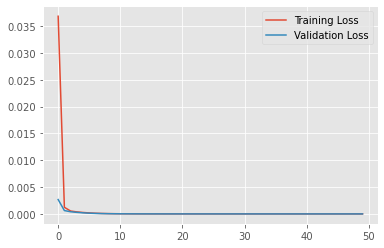

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

学習データのMAEを確認

In [22]:
x_train_predict_result2 = model2.predict(x_train)

In [23]:
train_abs2 = np.abs(x_train_predict_result2 - x_train)
train_mae2 = np.mean(train_abs2, axis=1)
train_mae2 = train_mae2.reshape(-1)

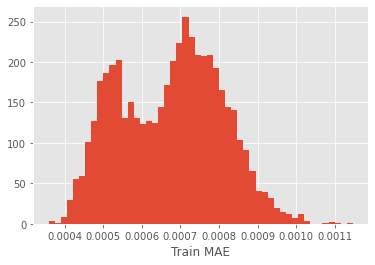

In [24]:
plt.hist(train_mae2, bins=50)
plt.xlabel("Train MAE")
plt.show()

In [25]:
threshold2 = np.max(train_mae2)
print(threshold2)

0.0011473476984732332


テストデータのMAEを確認

In [26]:
x_test_predict_result2 = model2.predict(x_test)

In [27]:
test_abs2 = np.abs(x_test_predict_result2 - x_test)
test_mae2 = np.mean(test_abs2, axis=1)
test_mae2 = test_mae2.reshape(-1)

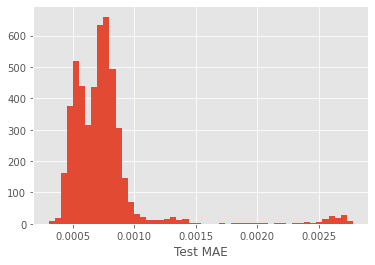

In [28]:
plt.hist(test_mae2, bins=50)
plt.xlabel("Test MAE")
plt.show()

In [29]:
anomaly_result2 = test_mae2 > threshold2
print(np.sum(anomaly_result2))
print(np.where(anomaly_result2))

226
(array([4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142,
       4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153,
       4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164,
       4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175,
       4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186,
       4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197,
       4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208,
       4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219,
       4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230,
       4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241,
       4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252,
       4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263,
       4264, 4265, 4266, 4267, 4268, 4413, 4414, 4415, 4416, 4417, 4418,
       4419, 4420, 4421, 4422, 4423, 4424, 442

異常検知したデータの位置を赤で塗りつぶして確認

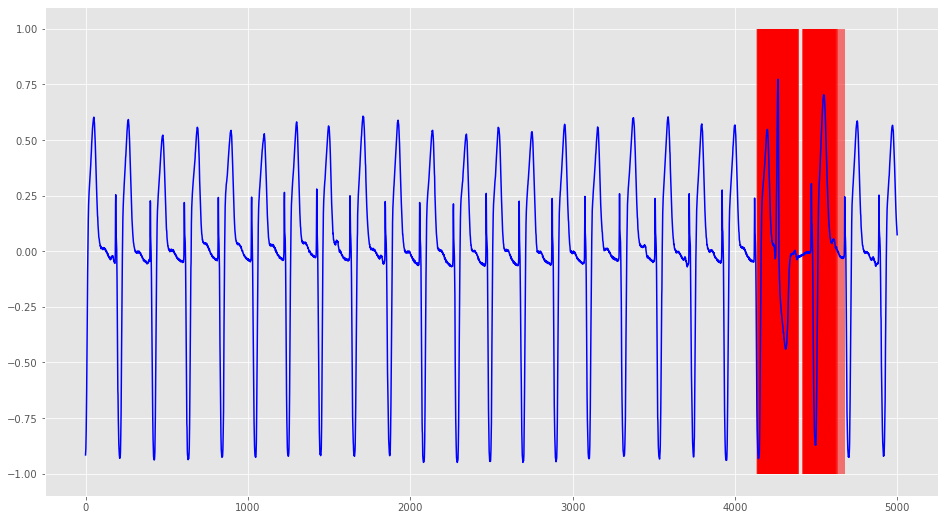

In [30]:
plt.figure(figsize=(16, 9))

plt.plot(test_data, color="b")

for index, anomaly in enumerate(anomaly_result2):
    if anomaly:
        x = np.arange(index, index + TIME_STEPS)
        y1 = [-1] * len(x)
        y2 = [1] * len(x)
        plt.fill_between(x, y1, y2, facecolor="r", alpha=0.3)